# Prepare Vector DB

Was ultimately useless as I didn't have enough time to implement a RAG :(

In [1]:
!pip install -q lancedb imagehash

In [ ]:
import os
import json

import numpy as np
import lancedb
import pandas as pd
import imagehash
from PIL import Image
from PIL.Image import Image as PILImage

## Load the Dataset

In [3]:
df_data_list = []

### Phase 1

In [4]:
phase_1_datasets = [
    # 'docvqa',
    # 'funsd',
    # 'iconqa_choose_txt',
    # 'iconqa_fill_in_blank',
    'infographicvqa',
    # 'tabfact',
    'textbookqa',
    # 'wildreceipt',
    # 'wtq',
    # 'websrc',
]

In [ ]:
%%time
for split in ['train', 'val', 'test']:
    for dataset_name in phase_1_datasets:
        dataset_path = os.path.join("data/processed_data", dataset_name, f'converted_output_{split}.json')
        assert os.path.exists(dataset_path)
        
        df_data = pd.read_json(dataset_path)
        df_data["id"] = dataset_name + "_" + df_data["id"]
        df_data["dataset"] = dataset_name
        df_data["slice"] = split

        df_data_list.append(df_data)

### Phase 2

In [6]:
phase_2_datasets = ["mychart", "mydoc", "myinfographic"]

In [7]:
split = "test"
for dataset_name in phase_2_datasets:
    dataset_path = os.path.join("data/raw_datasets", dataset_name, "annot_wo_answer.json")
    print(dataset_path)
    assert os.path.exists(dataset_path)

    df_data = pd.read_json(dataset_path)
    df_data["dataset"] = dataset_name
    df_data["slice"] = split

    df_data_list.append(df_data)

data/raw_datasets/mychart/annot_wo_answer.json
data/raw_datasets/mydoc/annot_wo_answer.json
data/raw_datasets/myinfographic/annot_wo_answer.json


## Init VectorDB

### Prepare LanceDB

In [8]:
uri = "data/lancedb"
db = lancedb.connect(uri)

In [9]:
db.table_names()

['mmfm']

### Declare schema

### Create table

In [10]:
%%time
if "mmfm" in db.table_names():
    db.drop_table("mmfm")

mmfm_table = db.create_table("mmfm", data=pd.concat(df_data_list))

CPU times: user 142 ms, sys: 90.6 ms, total: 232 ms
Wall time: 294 ms


In [11]:
db.table_names()

['mmfm']

In [12]:
mmfm_table.schema

id: string
image: string
conversations: list<item: struct<from: string, value: string>>
  child 0, item: struct<from: string, value: string>
      child 0, from: string
      child 1, value: string
dataset: string
slice: string

In [13]:
%%time
df_mmfm = mmfm_table.to_pandas()

CPU times: user 96.1 ms, sys: 128 ms, total: 224 ms
Wall time: 152 ms


In [14]:
df_mmfm.sample(3)

id  \
15627  infographicvqa_infographicvqa_0_2906_0   
5206   infographicvqa_infographicvqa_0_1010_1   
36966                      myinfographic_4133   

                                     image  \
15627  raw_datasets/infovqa/jpgs/32520.jpg   
5206   raw_datasets/infovqa/jpgs/45518.jpg   
36966             _53f9b07a43e61_w1500.jpg   

                                           conversations         dataset  \
15627  [{'from': 'human', 'value': '<image>
Answer sh...  infographicvqa   
5206   [{'from': 'human', 'value': '<image>
Respond t...  infographicvqa   
36966  [{'from': 'human', 'value': '<image>
What is t...   myinfographic   

       slice  
15627  train  
5206   train  
36966   test

In [15]:
len(df_mmfm)

37044

In [16]:
len(df_mmfm[df_mmfm["dataset"] == "mydoc"])

400

## Add Image Hashes

In [17]:
def get_image_hash(img: PILImage):
    # manual hyperparameter
    hash_dim = 32
    img_hash = imagehash.whash(img, hash_dim)
    return img_hash

In [ ]:
df_mmfm.iloc[36966]["conversations"]

In [ ]:
%%time
image = Image.open("data/raw_datasets/myinfographic/images/_53f9b07a43e61_w1500.jpg").convert('RGB')
image_hash = get_image_hash(image)
flattened_image_hash = np.array(image_hash.hash, np.int8).flatten()

In [ ]:
flattened_image_hash.sum(), len(flattened_image_hash)

In [ ]:
flattened_image_hash

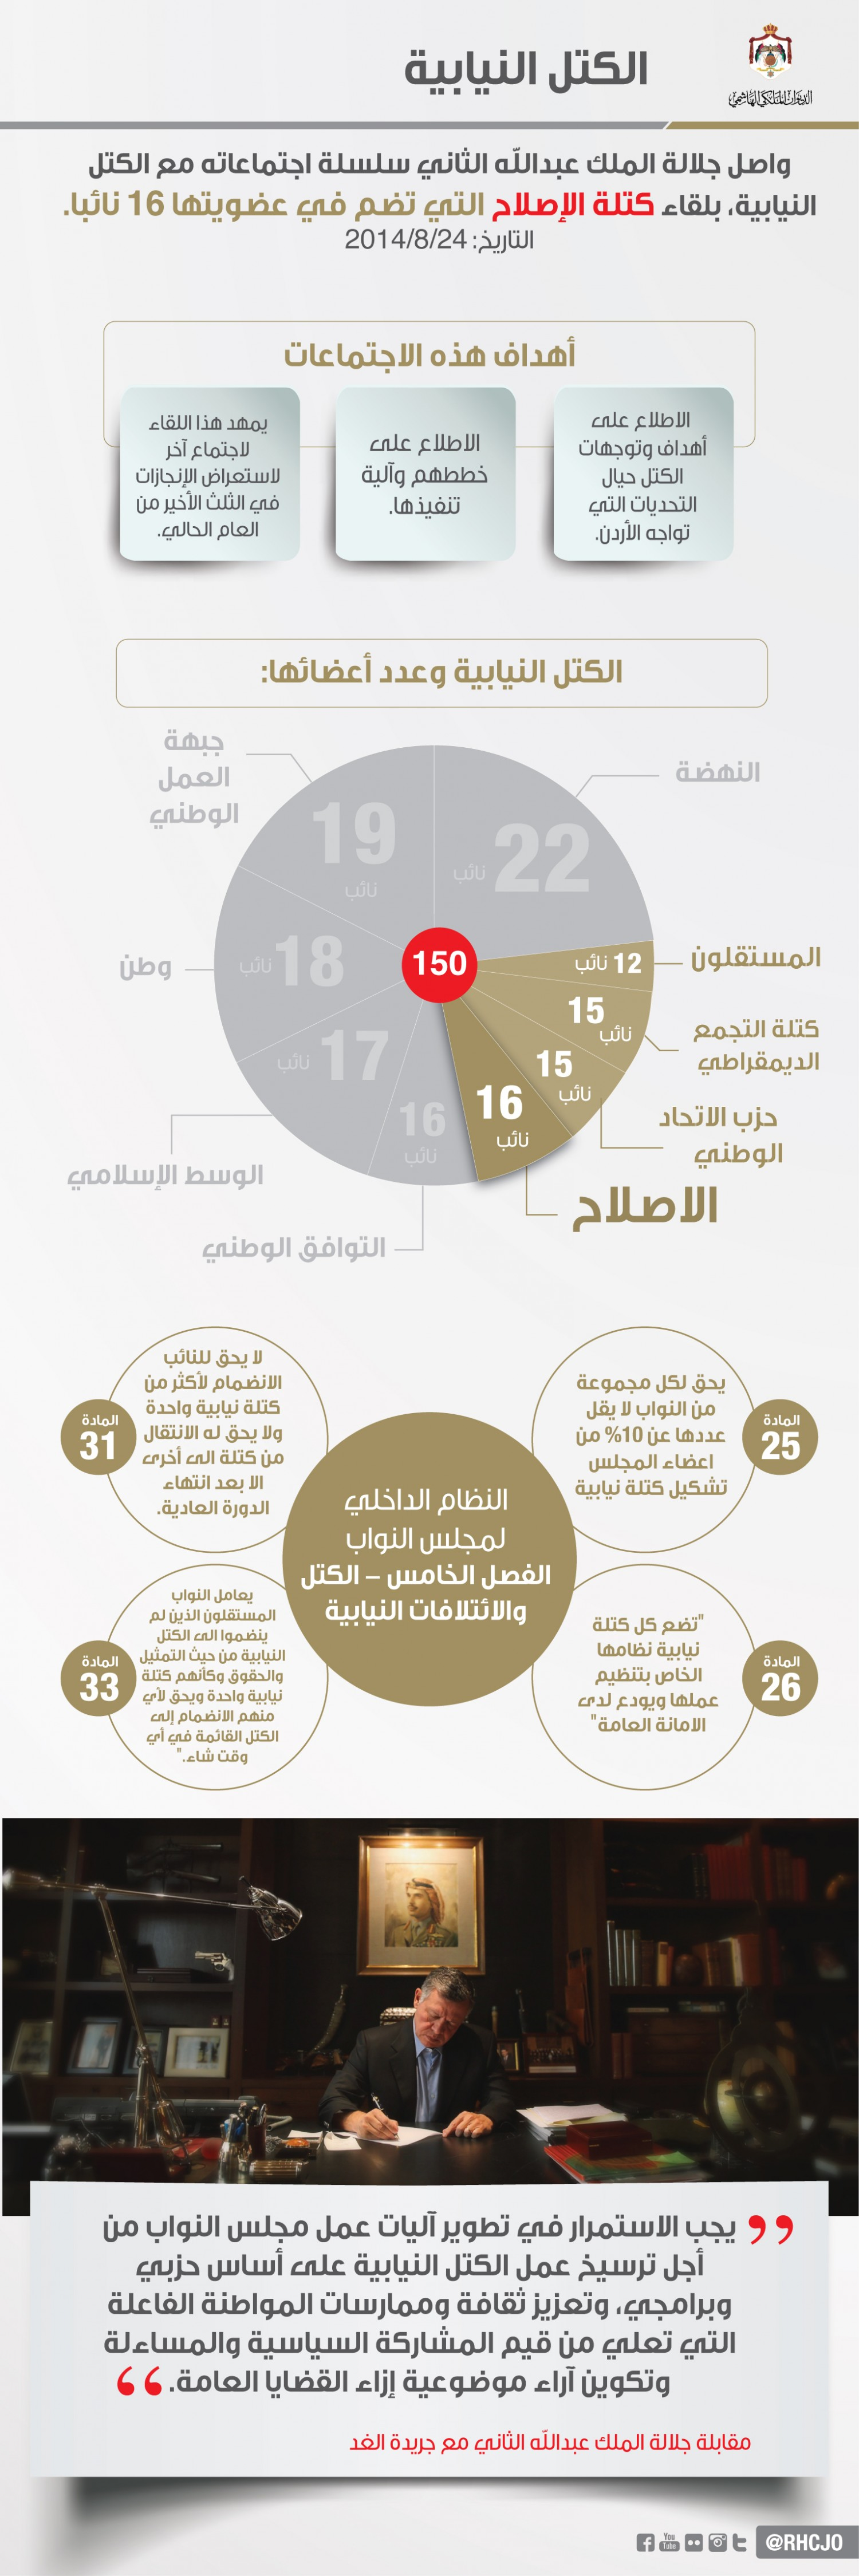

In [37]:
image

In [ ]:
0.153*len(df_mmfm)/6/3600